In [1]:
import urllib.parse

import mlflow

# MLFlow creds
MLFLOW_DOMAIN = "mlflow.gritans.lv"
MLFLOW_USERNAME = "data_user"
MLFLOW_PASSWORD = "ais7Rah2foo0gee9"
MLFLOW_TRACKING_URI = f"https://{MLFLOW_DOMAIN}"

parsed_uri = urllib.parse.urlparse(MLFLOW_TRACKING_URI)
auth_uri = parsed_uri._replace(
    netloc=f"{urllib.parse.quote(MLFLOW_USERNAME)}:{urllib.parse.quote(MLFLOW_PASSWORD)}@{parsed_uri.netloc}"
).geturl()

mlflow.set_tracking_uri(auth_uri)


import mlflow.pyfunc

model_name = "working_nist"
model_version = 1

uri = f"models:/{model_name}/{model_version}"
model = mlflow.pyfunc.load_model(uri)

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from utils.misc import interpolate
import numpy as np
import re

def parse_jdx(file_path: str) -> dict[np.ndarray, np.ndarray]:
    with open(file_path, 'r', encoding='latin1') as f:
        lines = f.readlines()

    x_vals = []
    y_vals = []
    delta_x = None
    x_factor = 1.0
    y_factor = 1.0
    reading_data = False

    for line in lines:
        line = line.strip()
        if line.startswith("##DELTAX="):
            delta_x = float(line.split("=", 1)[1])
        elif line.startswith("##XFACTOR="):
            x_factor = float(line.split("=", 1)[1])
            continue
        elif line.startswith("##YFACTOR="):
            y_factor = float(line.split("=", 1)[1])
            continue
        elif line.startswith("##XYDATA="):
            reading_data = True
            continue
        elif line.startswith("##END="):
            break
        elif line.startswith("##"):
            continue
        elif reading_data:
            raw_tokens = re.split(r"(\s+|-)", line)
            tokens = []
            make_negative = False
            for token in raw_tokens:
                token = token.strip()
                if not token:
                    continue
                if token == '-':
                    make_negative = True
                elif token not in ('-', ''):
                    num = float(token)
                    if make_negative:
                        num = -num
                        make_negative = False
                    tokens.append(num)

            base_x = tokens[0]
            for i, y_str in enumerate(tokens[1:]):
                x_vals.append(base_x + i * delta_x)
                y_vals.append(float(y_str))

    x_scaled = np.array(x_vals) * x_factor
    y_scaled = np.array(y_vals) * y_factor

    return {'spectrum_x': x_scaled, 'spectrum_y': y_scaled}

sample = parse_jdx("./67-56-1-IR.jdx")

In [15]:
vals = [x[2] for x in model.predict(sample)[0]['attention'][0]]
a = np.array(vals)
a.min(), a.max(), a.mean(), a.std()

(0.0, 1.0, 0.06983276829338081, 0.17407363610009038)

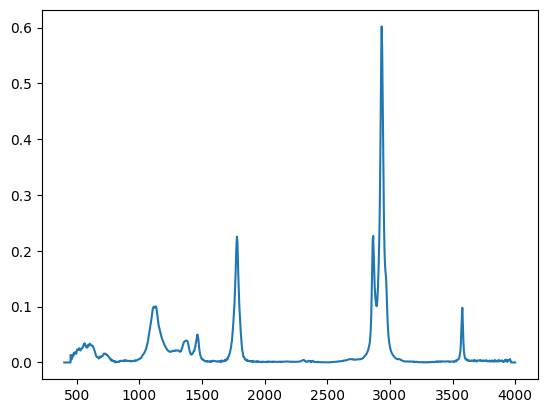

In [19]:
import numpy as np
import matplotlib.pyplot as plt
y = np.load("./57103.npy")
x = np.linspace(400, 4000, len(y))
plt.plot(x, y)


In [3]:
"""
Load samples from ../data/ftir/test/
each sample is {id}.npy for the spectrum (only y values, already interpolated to 400-4000) and {id}.txt for the labels.

validate the model using nn.forward.
in particular, find the exact match ratio
"""

import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Directory containing test data
test_dir = "./data/ftir/test/"

# Get all test IDs (files without extensions)
test_files = [f.split(".")[0] for f in os.listdir(test_dir) if f.endswith(".npy")]
test_ids = list(set(test_files))
print(f"Found {len(test_ids)} test samples")

# Set threshold for prediction
threshold = 0.5

# Create x-axis for all spectra (already interpolated 400-4000 cm⁻¹)
x = np.linspace(400, 4001, 3602)

# Track results
all_true_labels = []
all_pred_labels = []
exact_matches = 0

# Process each test sample
for sample_id in tqdm(test_ids):
    # Load spectrum (y values)
    spectrum_y = np.load(f"{test_dir}/{sample_id}.npy")

    # torch_y = torch.from_numpy(spectrum_y).float()
    # torch_y = model.unwrap_python_model().spectrum_eval_transform(torch_y)

    # np_y = torch_y.cpu().numpy()

    # Load ground truth labels
    with open(f"{test_dir}/{sample_id}.txt", 'r') as f:
        line = f.readline().strip()
        binary_values = [int(val) for val in line.split()]

    # Get functional group names from the model
    fg_names = model.unwrap_python_model().fg_names

    # Create true_labels list by including only the positive classes
    true_labels = [fg_names[i] for i, val in enumerate(binary_values) if val == 1]    
    # Create DataFrame for model input
    df = pd.DataFrame([{'spectrum_x': x, 'spectrum_y': spectrum_y}])
    
    # Make prediction
    results = model.predict(data=df, params={"threshold": threshold})[0]
    pred_labels = results['positive_targets']
    
    # Compare results
    is_exact_match = set(true_labels) == set(pred_labels)
    if is_exact_match:
        exact_matches += 1
    
    # Store for overall metrics
    # Convert to binary format for metrics calculation
    true_binary = [1 if fg in true_labels else 0 for fg in model.unwrap_python_model().fg_names]
    pred_binary = [1 if fg in pred_labels else 0 for fg in model.unwrap_python_model().fg_names]
    
    all_true_labels.append(true_binary)
    all_pred_labels.append(pred_binary)

# Calculate metrics
exact_match_ratio = exact_matches / len(test_ids)
print(f"Exact Match Ratio: {exact_match_ratio:.4f} ({exact_matches}/{len(test_ids)})")

# Convert lists to numpy arrays for sklearn metrics
y_true = np.array(all_true_labels)
y_pred = np.array(all_pred_labels)

# Calculate precision, recall, F1 (micro and macro)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# print(f"Micro-averaged metrics:")
# print(f"  Precision: {precision_micro:.4f}")
# print(f"  Recall: {recall_micro:.4f}")
# print(f"  F1-score: {f1_micro:.4f}")

print(f"Macro-averaged metrics:")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")
print(f"  F1-score: {f1_macro:.4f}")

# Calculate hamming accuracy (proportion of correct labels)
hamming_accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
print(f"Hamming Accuracy: {hamming_accuracy:.4f}")

Found 933 test samples


100%|██████████| 933/933 [00:03<00:00, 280.75it/s]

Exact Match Ratio: 0.4319 (403/933)
Macro-averaged metrics:
  Precision: 0.7212
  Recall: 0.9397
  F1-score: 0.7913
Hamming Accuracy: 0.9395


In [4]:
# Import the metrics function used in training
from eval.metrics import compute_metrics

# Set the threshold to match training
threshold = 0.5  # Replace with your training threshold value

# Collect all predictions and targets
all_predictions = []
all_targets = []

# Process each test sample
for sample_id in tqdm(test_ids):
    # Load and process data as before
    spectrum_y = np.load(f"{test_dir}/{sample_id}.npy")
    
    # Apply the same transforms used during training
    torch_y = torch.from_numpy(spectrum_y).float()
    torch_y = model.unwrap_python_model().spectrum_eval_transform(torch_y)
    
    # Load ground truth labels
    with open(f"{test_dir}/{sample_id}.txt", 'r') as f:
        line = f.readline().strip()
        binary_values = [int(val) for val in line.split()]
    
    true_binary = torch.tensor(binary_values, dtype=torch.float)
    
    # Get model predictions (use the same processing as in training)
    df = pd.DataFrame([{'spectrum_x': x, 'spectrum_y': spectrum_y}])
    results = model.predict(data=df, params={"threshold": threshold})[0]
    pred_labels = results['positive_targets']
    
    pred_binary = torch.zeros_like(true_binary)
    for i, fg in enumerate(model.unwrap_python_model().fg_names):
        if fg in pred_labels:
            pred_binary[i] = 1.0
    
    all_predictions.append(pred_binary)
    all_targets.append(true_binary)

# Convert to tensors
predictions_tensor = torch.stack(all_predictions)
targets_tensor = torch.stack(all_targets)

# Use the same metrics function as during training
metrics = compute_metrics(predictions_tensor, targets_tensor)
for key, value in metrics.items():
    if "overall" in key:
        print(f"{key}: {value:.4f}")

100%|██████████| 933/933 [00:03<00:00, 276.06it/s]

overall_accuracy: 0.9395
overall_precision: 0.8170
overall_recall: 0.8979
overall_f1: 0.8556


Validating: 100%|██████████| 55/55 [00:01<00:00, 41.51it/s]



Overall Metrics:
Exact Match Ratio: 0.4430
Weighted F1 Score: 0.8726
Overall Accuracy: 0.9392
Overall Precision: 0.8159
Overall Recall: 0.8964
Overall F1: 0.8542

F1 Scores by Functional Group:
  alkane: F1=0.9130, Precision=0.9691, Recall=0.8631
  methyl: F1=0.8928, Precision=0.9493, Recall=0.8426
  alkene: F1=0.7196, Precision=0.6311, Recall=0.8369
  alkyne: F1=0.8936, Precision=0.8571, Recall=0.9333
  alcohols: F1=0.9134, Precision=0.8547, Recall=0.9808
  amines: F1=0.7800, Precision=0.6582, Recall=0.9571
  nitriles: F1=0.3325, Precision=0.2050, Recall=0.8800
  aromatics: F1=0.9659, Precision=0.9875, Recall=0.9452
  alkyl halides: F1=0.7385, Precision=0.6503, Recall=0.8545
  esters: F1=0.8545, Precision=0.7778, Recall=0.9479
  ketones: F1=0.7855, Precision=0.6980, Recall=0.8981
  aldehydes: F1=0.8039, Precision=0.6721, Recall=1.0000
  carboxylic acids: F1=0.8602, Precision=0.7843, Recall=0.9524
  ether: F1=0.9015, Precision=0.9005, Recall=0.9026
  acyl halides: F1=0.5373, Precision

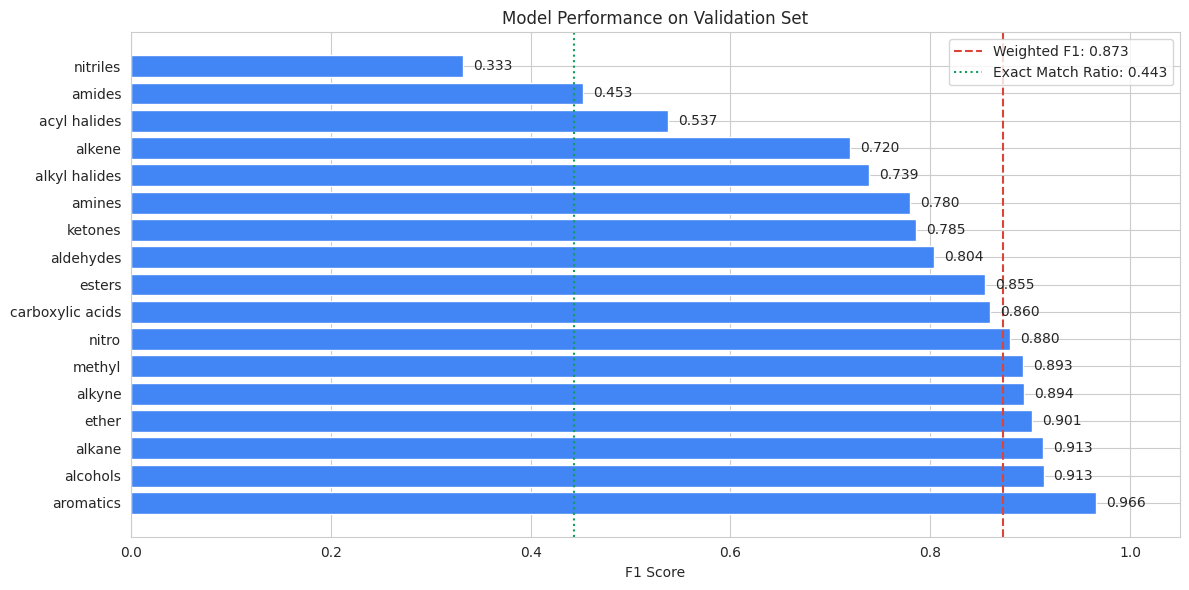

In [15]:
# Implement validation using the val_agg loader
import torch
import numpy as np
from tqdm import tqdm
from eval.metrics import compute_metrics

# Create validation loader
batch_size = 32  # You can adjust this based on your GPU memory
val_loader = val_agg.get_loader(batch_size=batch_size)

# Access the unwrapped model
unwrapped_model = model.unwrap_python_model()
nn_model = unwrapped_model.nn

weights = torch.load("./best_model.pt", map_location=torch.device('cpu'))
nn_model.load_state_dict(weights)

# Set the model to evaluation mode
nn_model.eval()
device = "cpu"

# Set the threshold similar to your training configuration
threshold = 0.5

# Prepare containers for predictions and targets
all_fg_preds = []
all_fg_targets = []

# Validation loop
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        # Move batch to appropriate device
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].to(device)
        
        # Forward pass
        outputs = nn_model(batch["spectrum"])
        
        # Get functional group logits and targets
        fg_logits = outputs["fg_logits"]
        fg_targets = batch["fg_targets"]
        
        # Apply sigmoid and threshold
        fg_probs = torch.sigmoid(fg_logits)
        fg_preds = (fg_probs > threshold).float()
        
        # Collect predictions and targets
        all_fg_preds.append(fg_preds.cpu())
        all_fg_targets.append(fg_targets.cpu())

# Concatenate all batches
all_fg_preds = torch.cat(all_fg_preds, dim=0)
all_fg_targets = torch.cat(all_fg_targets, dim=0)

# Compute metrics
metrics = compute_metrics(all_fg_preds, all_fg_targets)

# Print overall metrics
print("\nOverall Metrics:")
print(f"Exact Match Ratio: {metrics['exact_match_ratio']:.4f}")
print(f"Weighted F1 Score: {metrics['weighted_avg_f1']:.4f}")
print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
print(f"Overall Precision: {metrics['overall_precision']:.4f}")
print(f"Overall Recall: {metrics['overall_recall']:.4f}")
print(f"Overall F1: {metrics['overall_f1']:.4f}")

# Print per-functional group metrics
print("\nF1 Scores by Functional Group:")
for i, fg_name in enumerate(cfg.fg_names):
    f1 = metrics['per_target_f1'][i]
    precision = metrics['per_target_precision'][i]
    recall = metrics['per_target_recall'][i]
    print(f"  {fg_name}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# Create visualizations of the results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sort functional groups by F1 score
fg_metrics = [(fg, metrics['per_target_f1'][i]) 
              for i, fg in enumerate(cfg.fg_names)]
fg_metrics.sort(key=lambda x: x[1], reverse=True)

# Plot F1 scores
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
bars = plt.barh([x[0] for x in fg_metrics], [x[1] for x in fg_metrics], color='#4285F4')

# Add value labels
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{fg_metrics[i][1]:.3f}', va='center')

# Add a vertical line for weighted average
plt.axvline(metrics['weighted_avg_f1'], color='#DB4437', linestyle='--', 
            label=f'Weighted F1: {metrics["weighted_avg_f1"]:.3f}')

# Add a vertical line for exact match ratio
plt.axvline(metrics['exact_match_ratio'], color='#0F9D58', linestyle=':', 
            label=f'Exact Match Ratio: {metrics["exact_match_ratio"]:.3f}')

plt.xlabel('F1 Score')
plt.title('Model Performance on Validation Set')
plt.xlim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
y = batch['spectrum'][0].cpu().detach().numpy()
print(y.min(), y.max(), y.mean(), y.std())
ty = torch.from_numpy(y).float()
ty = val_agg.datasets['nist'].spectrum_transform(ty)
print(ty.min(), ty.max(), ty.mean(), ty.std())

0.0 1.0 0.14080705 0.13542642
tensor(0.) tensor(1.) tensor(0.1408) tensor(0.1355)


0.0 1.0 0.10018242 0.15988576


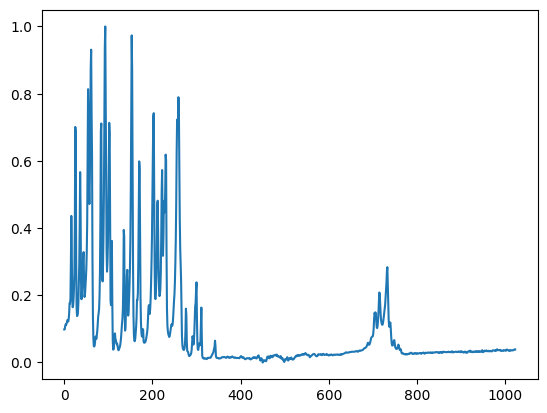

In [20]:
import matplotlib.pyplot as plt
y = train_agg.datasets['chemmotion'][200]['spectrum'].cpu().detach().numpy()
print(y.min(), y.max(), y.mean(), y.std())
plt.plot(y)

0.0 1.0 0.029307196 0.09322578


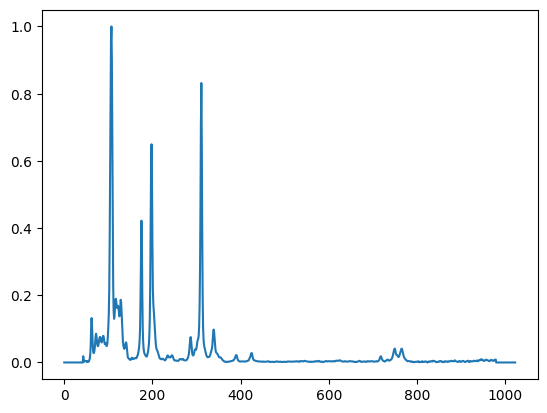

In [14]:
import matplotlib.pyplot as plt
y = train_agg.datasets['nist'][2]['spectrum'].cpu().detach().numpy()
print(y.min(), y.max(), y.mean(), y.std())
plt.plot(y)

/tmp/ipykernel_426121/968204881.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='weighted_f1', data=df_small_plots, ax=ax_wf1, palette=colors)
/tmp/ipykernel_426121/968204881.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='exact_match_ratio', data=df_small_plots, ax=ax_emr, palette=colors)
/tmp/ipykernel_426121/968204881.py:221: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/tmp/ipykernel_426121/968204881.py:221: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(
/tmp/ipykernel_426121/968204881.p

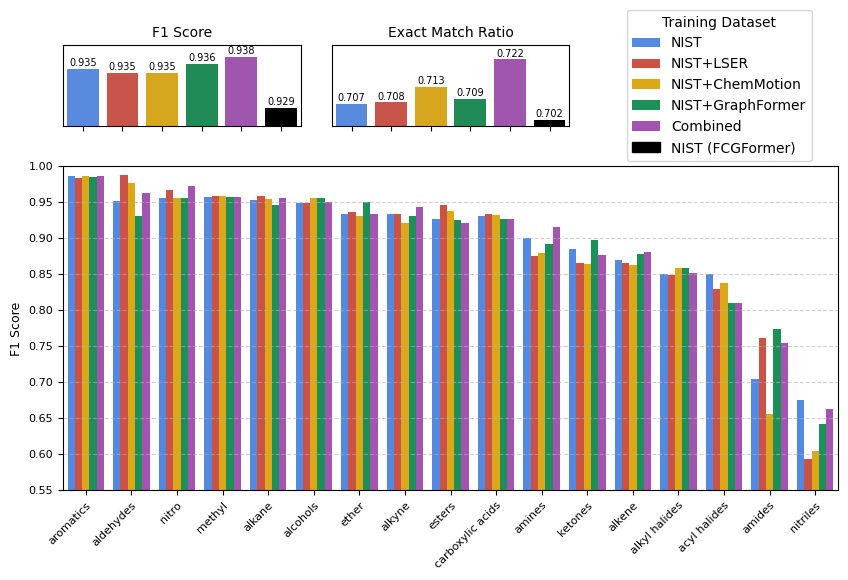

In [70]:
# python vis.py 7d6fcfa3414748119e8d452bffa2e3d3
nist_scores = """
  aromatics: 0.9865
  methyl: 0.9575
  nitro: 0.9560
  alkane: 0.9531
  aldehydes: 0.9512
  alcohols: 0.9488
  ether: 0.9335
  alkyne: 0.9333
  carboxylic acids: 0.9302
  esters: 0.9270
  amines: 0.9009
  ketones: 0.8854
  alkene: 0.8692
  alkyl halides: 0.8508
  acyl halides: 0.8500
  amides: 0.7042
  nitriles: 0.6748

Weighted F1: 0.9354
Exact Match Ratio: 0.7074
Epoch: 44.0
"""

# python vis.py f0878864036c40c0be506e6b6dce19f3
lser_scores = """
  aldehydes: 0.9877
  aromatics: 0.9835
  nitro: 0.9670
  alkane: 0.9585
  methyl: 0.9584
  alcohols: 0.9483
  esters: 0.9463
  ether: 0.9369
  carboxylic acids: 0.9339
  alkyne: 0.9333
  amines: 0.8750
  alkene: 0.8661
  ketones: 0.8650
  alkyl halides: 0.8488
  acyl halides: 0.8293
  amides: 0.7619
  nitriles: 0.5930

Weighted F1: 0.9348
Exact Match Ratio: 0.7079
"""

# python vis.py fcae93d1ffad4f79be9c7eba8b96030e
chem_scores = """
  aromatics: 0.9860
  aldehydes: 0.9762
  methyl: 0.9590
  alcohols: 0.9563
  nitro: 0.9560
  alkane: 0.9544
  esters: 0.9378
  carboxylic acids: 0.9328
  ether: 0.9311
  alkyne: 0.9213
  amines: 0.8800
  ketones: 0.8644
  alkene: 0.8627
  alkyl halides: 0.8586
  acyl halides: 0.8372
  amides: 0.6563
  nitriles: 0.6047

Weighted F1: 0.9348
Exact Match Ratio: 0.7131
"""

# python vis.py 3e3a731e8f5145879c48f048cf1736f2
graph_scores = """
  aromatics: 0.9846
  methyl: 0.9566
  nitro: 0.9560
  alcohols: 0.9555
  ether: 0.9505
  alkane: 0.9463
  aldehydes: 0.9302
  alkyne: 0.9302
  carboxylic acids: 0.9266
  esters: 0.9246
  ketones: 0.8981
  amines: 0.8922
  alkene: 0.8774
  alkyl halides: 0.8580
  acyl halides: 0.8095
  amides: 0.7742
  nitriles: 0.6415

Weighted F1: 0.9363
Exact Match Ratio: 0.7091
"""

# python vis.py 99b6f602d24a4f5eb26a819e4d21b556
combined_scores = """
  aromatics: 0.9865
  nitro: 0.9727
  aldehydes: 0.9630
  methyl: 0.9574
  alkane: 0.9559
  alcohols: 0.9508
  alkyne: 0.9438
  ether: 0.9333
  carboxylic acids: 0.9266
  esters: 0.9215
  amines: 0.9152
  alkene: 0.8814
  ketones: 0.8770
  alkyl halides: 0.8522
  acyl halides: 0.8095
  amides: 0.7541
  nitriles: 0.6622

Weighted F1: 0.9375
Exact Match Ratio: 0.7224
"""

scores = [nist_scores, lser_scores, chem_scores, graph_scores, combined_scores]

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ####################################################################
# ### CHANGE 1: Import mpatches to manually create a legend item ###
# ####################################################################
import matplotlib.patches as mpatches

# Parse and prepare data (unchanged)
model_names = ["NIST", "NIST+LSER", "NIST+ChemMotion", "NIST+GraphFormer", "Combined"]

def parse_scores(score_str):
    scores = {}
    for line in score_str.strip().split('\n'):
        line = line.strip()
        if ': ' in line:
            parts = line.split(': ')
            key = parts[0].strip()
            try:
                value = float(parts[1])
                if key.startswith('Weighted F1'): scores['weighted_f1'] = value
                elif key.startswith('Exact Match Ratio'): scores['exact_match_ratio'] = value
                elif key.startswith('Epoch'): scores['epoch'] = value
                else: scores[key] = value
            except: pass
    return scores

parsed_scores = []
for i, score_str in enumerate(scores):
    scores_dict = parse_scores(score_str)
    scores_dict['model'] = model_names[i]
    parsed_scores.append(scores_dict)

df = pd.DataFrame(parsed_scores)
model_cols = ['model', 'weighted_f1', 'exact_match_ratio', 'epoch']
fg_cols = [col for col in df.columns if col not in model_cols]

# This DataFrame is for the MAIN plot and remains UNCHANGED
fg_df = pd.melt(df, id_vars=['model'], value_vars=fg_cols,
                var_name='Functional Group', value_name='F1 Score')

fg_avg = fg_df.groupby('Functional Group')['F1 Score'].mean().reset_index()
fg_avg = fg_avg.sort_values('F1 Score', ascending=False)
fg_order = fg_avg['Functional Group'].tolist()

# Create a new DataFrame for the small plots and add the manual entry.
new_entry_data = {
    'model': 'FCGFormer',
    'weighted_f1': 0.929,
    'exact_match_ratio': 0.702,
    'epoch': np.nan
}
df_small_plots = pd.concat([df, pd.DataFrame([new_entry_data])], ignore_index=True)

# Figure setup
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(10, 5.5))
gs = fig.add_gridspec(2, 6, height_ratios=[1, 4], wspace=0.3)

ax_wf1 = fig.add_subplot(gs[0, 0:2])
ax_emr = fig.add_subplot(gs[0, 2:4])
ax_legend = fig.add_subplot(gs[0, 4:6])
ax_main = fig.add_subplot(gs[1, :])

colors = ['#4285F4', '#DB4437', '#F4B400', '#0F9D58', '#AB47BC', '#000000']

# Weighted F1 plot (uses df_small_plots)
sns.barplot(x='model', y='weighted_f1', data=df_small_plots, ax=ax_wf1, palette=colors)
ax_wf1.set_title('F1 Score', fontsize=10)
ax_wf1.set_xlabel('')
ax_wf1.set_ylabel('')
ax_wf1.set_xticklabels([])
ax_wf1.set_yticks([])
y_min = 0.926 #min(df_small_plots['weighted_f1']) - 0.0005
y_max = max(df_small_plots['weighted_f1']) + 0.002
ax_wf1.set_ylim(y_min, y_max)
for i, v in enumerate(df_small_plots['weighted_f1']):
    ax_wf1.text(i, v + 0.0005, f'{v:.3f}', ha='center', fontsize=7)
ax_wf1.grid(axis='y', linestyle='--', alpha=0.7)

# Exact Match Ratio plot (uses df_small_plots)
sns.barplot(x='model', y='exact_match_ratio', data=df_small_plots, ax=ax_emr, palette=colors)
ax_emr.set_title('Exact Match Ratio', fontsize=10)
ax_emr.set_xlabel('')
ax_emr.set_ylabel('')
ax_emr.set_xticklabels([])
ax_emr.set_yticks([])
y_min = 0.7 #min(df_small_plots['exact_match_ratio']) - 0.002
y_max = max(df_small_plots['exact_match_ratio']) + 0.005
ax_emr.set_ylim(y_min, y_max)
for i, v in enumerate(df_small_plots['exact_match_ratio']):
    ax_emr.text(i, v + 0.001, f'{v:.3f}', ha='center', fontsize=7)
ax_emr.grid(axis='y', linestyle='--', alpha=0.7)

# Main plot (uses original fg_df)
sns.barplot(
    x='Functional Group',
    y='F1 Score',
    hue='model',
    data=fg_df,
    order=fg_order,
    ax=ax_main,
    palette=colors,
    saturation=0.8,
    errwidth=0,
)

ax_main.set_xlabel('')
ax_main.set_ylabel('F1 Score', fontsize=9)
ax_main.set_ylim(0.55, 1.0)
ax_main.grid(axis='y', linestyle='--', alpha=0.6)


# ####################################################################
# ### CHANGE 2: Manually build the complete legend               ###
# ####################################################################

# 1. Get handles/labels from the main plot (first 5 entries)
handles, labels = ax_main.get_legend_handles_labels()

# 2. Create a patch for the "Manual Entry"
manual_entry_label = 'NIST (FCGFormer)'
manual_entry_color = colors[5]  # The 6th color
manual_entry_handle = mpatches.Patch(color=manual_entry_color, label=manual_entry_label)

# 3. Append the new handle and label to the lists
handles.append(manual_entry_handle)
labels.append(manual_entry_label)

# 4. Create the legend with the complete lists
ax_legend.axis('off')
ax_legend.legend(handles=handles, labels=labels, loc='center', fontsize=10, title='Training Dataset', title_fontsize=10)

# 5. Remove the auto-generated legend from the main plot
ax_main.get_legend().remove()


# Final plot adjustments
plt.setp(ax_main.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=8)
ax_main.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()